In [ ]:
# pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   --------------------------------------- 625.1/625.1 kB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 38.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
import seaborn as sns 

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [5]:
weather_df = pd.read_csv('delhi_dewpoint.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,dewpoint
datetime_utc,
1996-11-01 11:00:00,9.0
1996-11-01 12:00:00,10.0
1996-11-01 13:00:00,11.0
1996-11-01 14:00:00,10.0
1996-11-01 16:00:00,11.0


In [6]:
weather_df.dtypes

dewpoint    float64
dtype: object

In [7]:
weather_df.index.dtype
#<M8[ns] is a specific dtype of datetime

dtype('<M8[ns]')

In [8]:
#weather_df.index = pd.to_datetime(weather_df.index)
weather_df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=100990, freq=None)

In [9]:
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    percent = percent*100
    
    print('Count of missing data : \n',total)
    print('% of missing data : \n',percent)

list_and_visualize_missing_data(weather_df)

Count of missing data : 
 dewpoint    621
dtype: int64
% of missing data : 
 dewpoint    0.614912
dtype: float64


In [10]:
#Fill missing data with forward fill
weather_df.fillna(weather_df.mean())
print('Count of missing data : ',weather_df[weather_df.isnull()].count())

Count of missing data :  dewpoint    0
dtype: int64


In [11]:
weather_df.describe()

,dewpoint
count,100369.000000
mean,15.741205
std,7.058587
min,-24.000000
25%,10.000000
50%,15.000000
75%,22.000000
max,75.000000


In [12]:
weather_df.describe()

,dewpoint
count,100369.000000
mean,15.741205
std,7.058587
min,-24.000000
25%,10.000000
50%,15.000000
75%,22.000000
max,75.000000


In [13]:
weather_df.head()

,dewpoint
datetime_utc,
1996-11-01 11:00:00,9.0
1996-11-01 12:00:00,10.0
1996-11-01 13:00:00,11.0
1996-11-01 14:00:00,10.0
1996-11-01 16:00:00,11.0


array([<Axes: xlabel='datetime_utc'>], dtype=object)

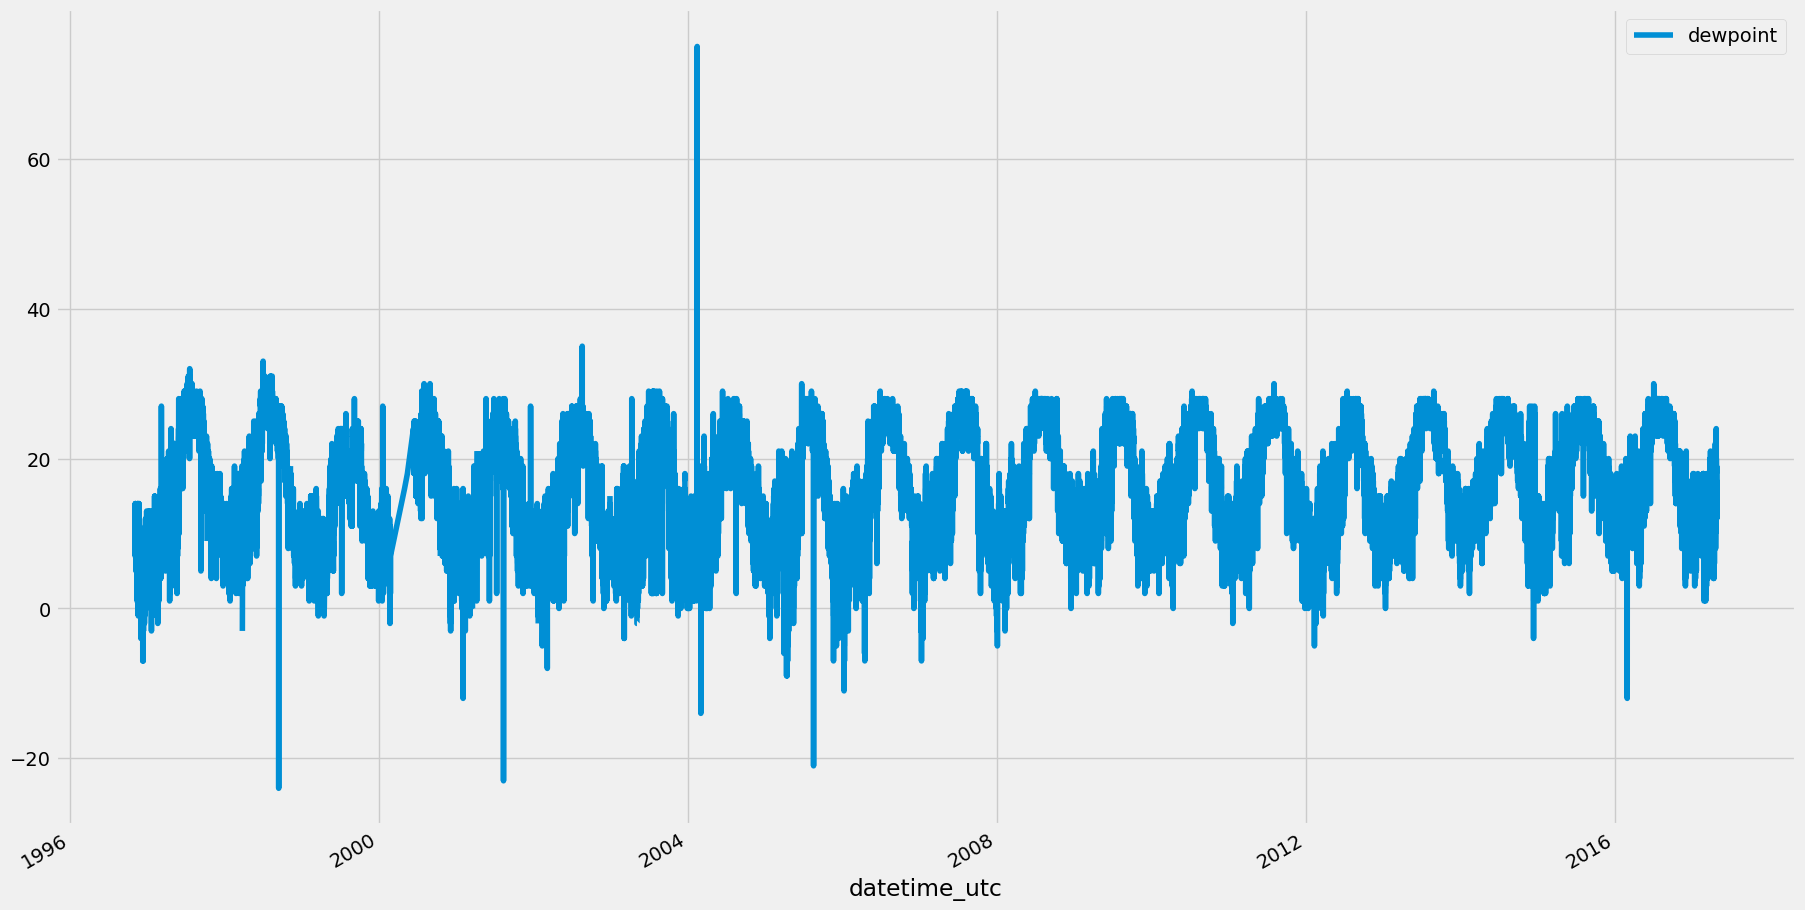

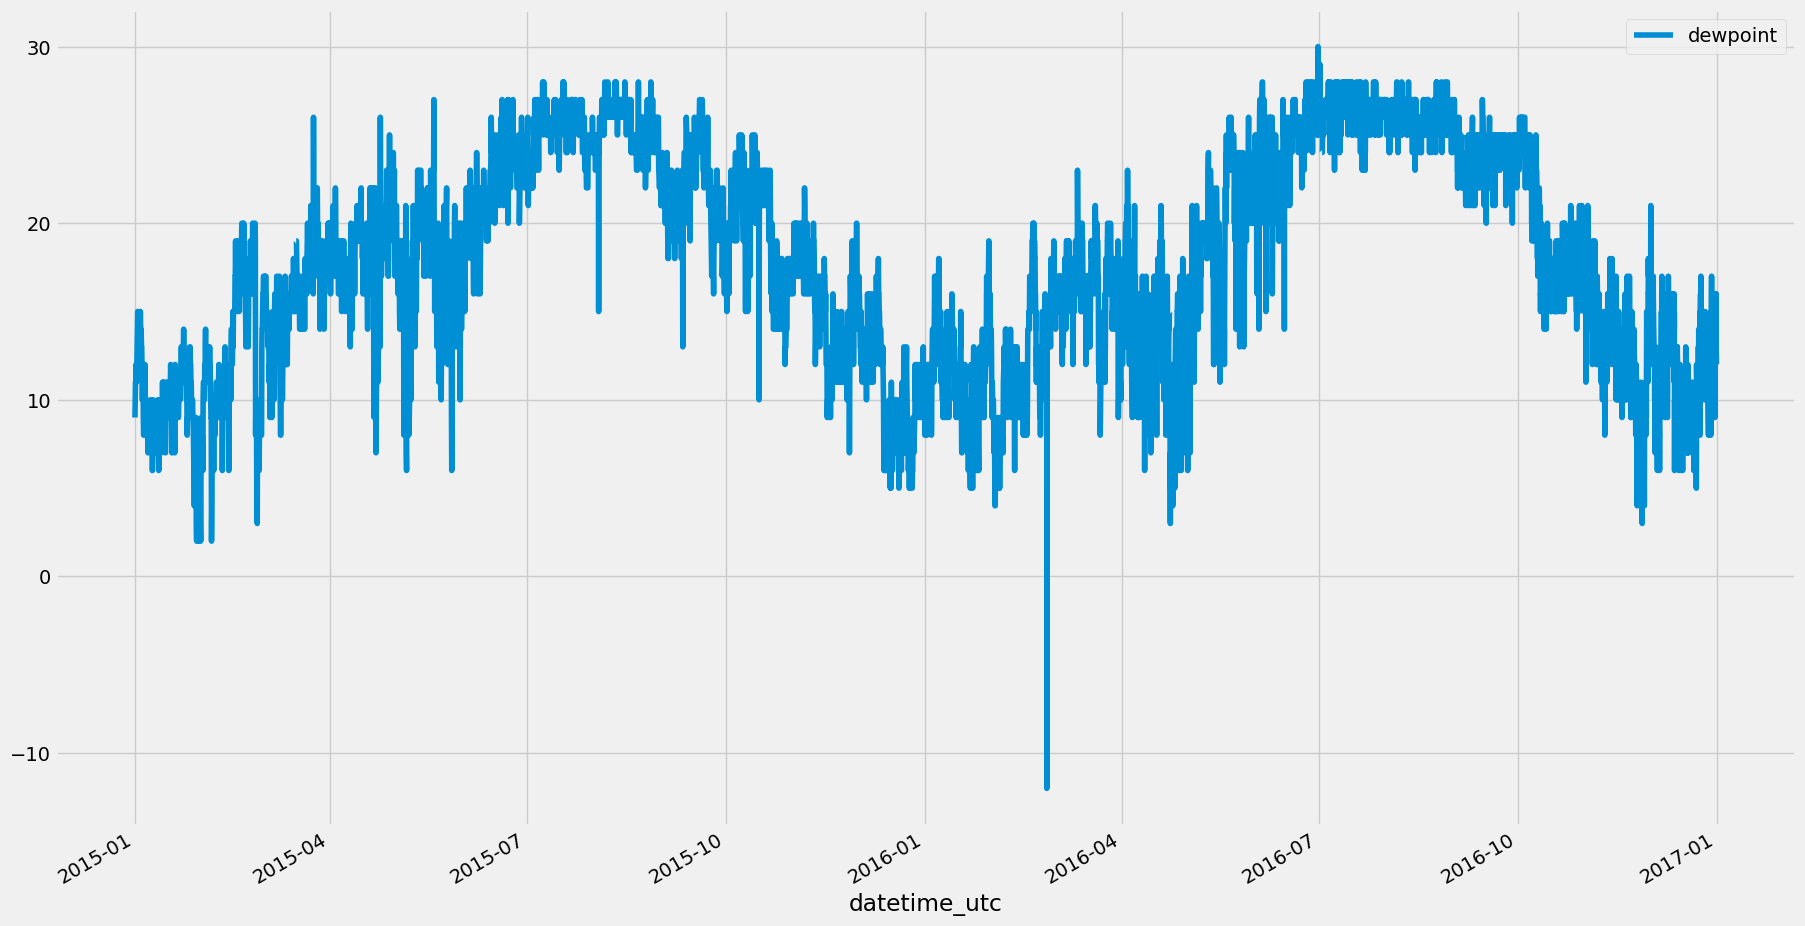

In [14]:
#check trend and seasonality of weather data
weather_df.plot(subplots=True, figsize=(20,12))
#detailed view of 2015 year
weather_df['2015':'2016'].resample('D')
weather_df['2015':'2016'].fillna(weather_df['2015':'2016']['dewpoint'].mean())
weather_df['2015':'2016'].plot(subplots=True, figsize=(20,12))

In [15]:
#split dataset into training and testing data
train_df = weather_df['2000':'2015'].resample('M').mean()
train_df = train_df.fillna(train_df.mean())
test_df = weather_df['2016':'2017'].resample('M').mean()
test_df = test_df.fillna(test_df.mean())

C:\Users\hp\AppData\Local\Temp\ipykernel_27064\945749017.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_df = weather_df['2000':'2015'].resample('M').mean()
C:\Users\hp\AppData\Local\Temp\ipykernel_27064\945749017.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_df = weather_df['2016':'2017'].resample('M').mean()


In [16]:
train_df.head()

,dewpoint
datetime_utc,
2000-01-31,9.171512
2000-02-29,9.825054
2000-03-31,16.207146
2000-04-30,16.000000
2000-05-31,18.000000


In [17]:
train_df.describe()

,dewpoint
count,192.000000
mean,16.207146
std,6.162553
min,6.079710
25%,10.846053
50%,15.457469
75%,22.026708
max,26.581731


In [18]:
test_df.head()

,dewpoint
datetime_utc,
2016-01-31,11.328165
2016-02-29,11.997449
2016-03-31,16.036093
2016-04-30,13.242358
2016-05-31,19.258824


In [19]:
test_df.describe()

,dewpoint
count,16.000000
mean,16.667893
std,5.581344
min,11.328165
25%,12.137058
50%,13.606825
75%,20.419485
max,26.324435


In [20]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

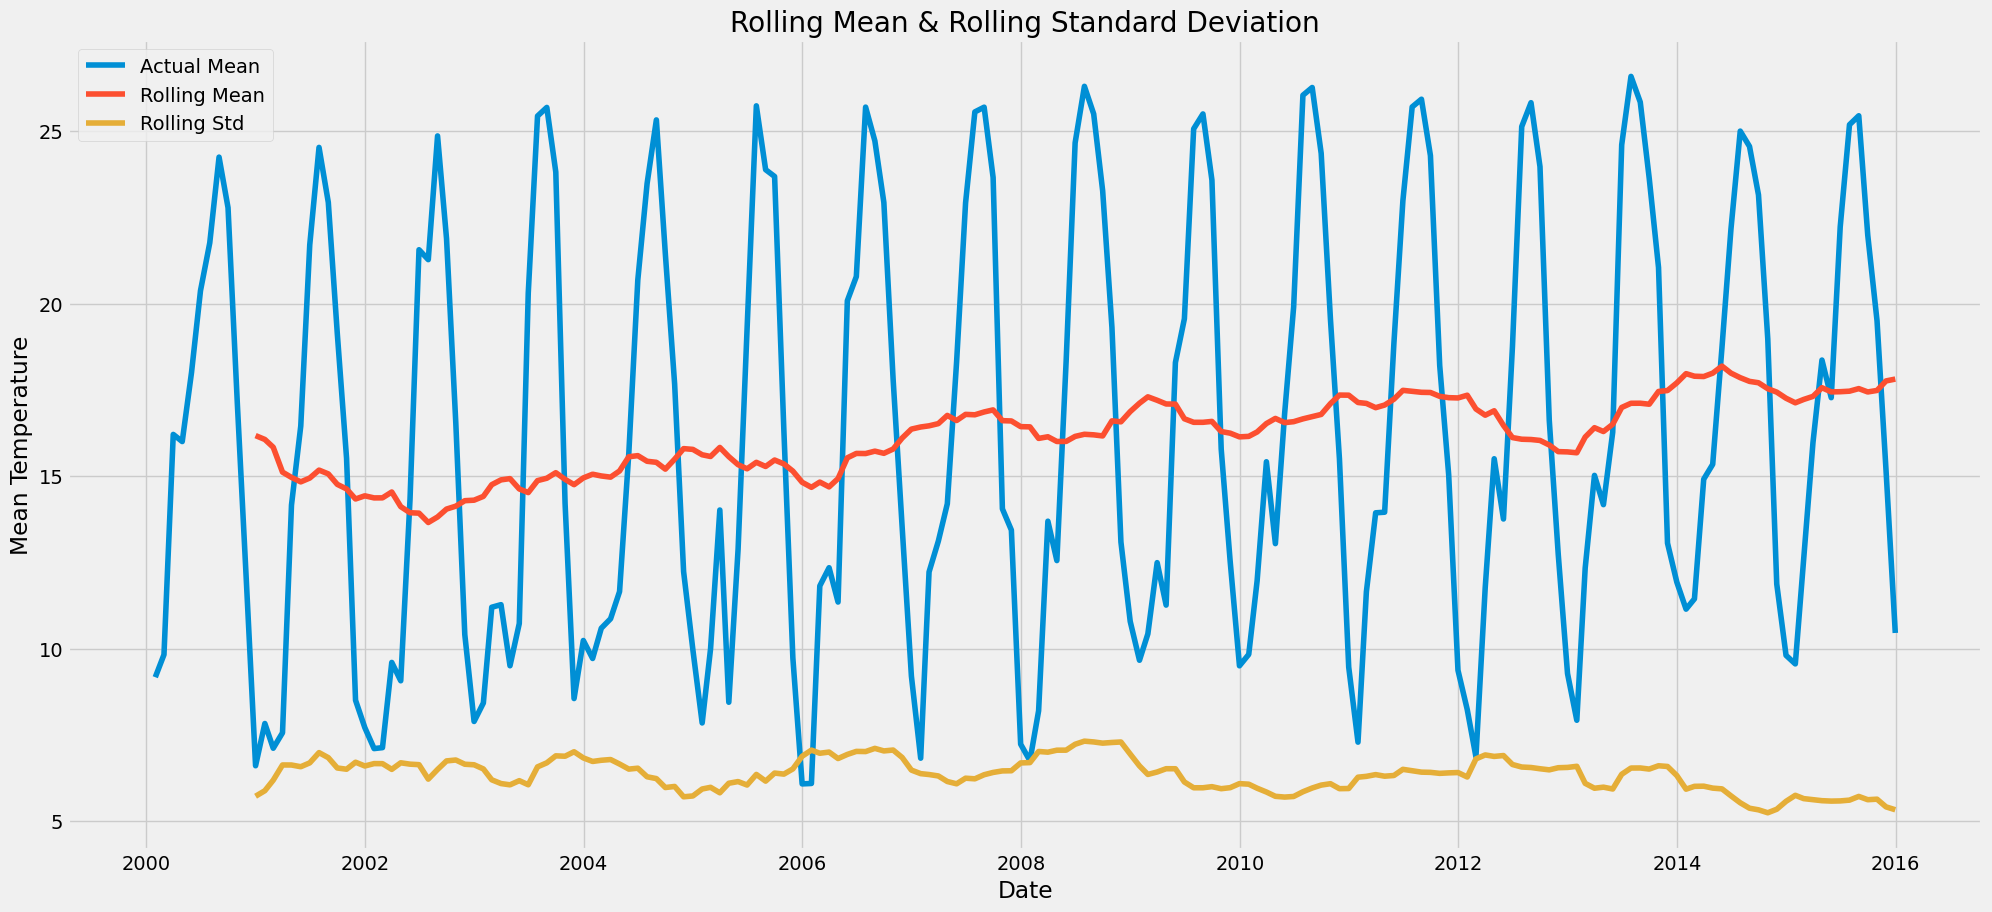

In [21]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train_df.dewpoint)

In [ ]:
model = pm.auto_arima(train_df, seasonal=True, m=12)

c:\Users\hp\.conda\envs\aienv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\.conda\envs\aienv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\.conda\envs\aienv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\.conda\envs\aienv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\.conda\envs\aienv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  

In [ ]:
forecast = model.predict(n_periods=len(test_df))

In [ ]:
forecast = pd.DataFrame(forecast,index = test_df.index,columns=['Prediction'])

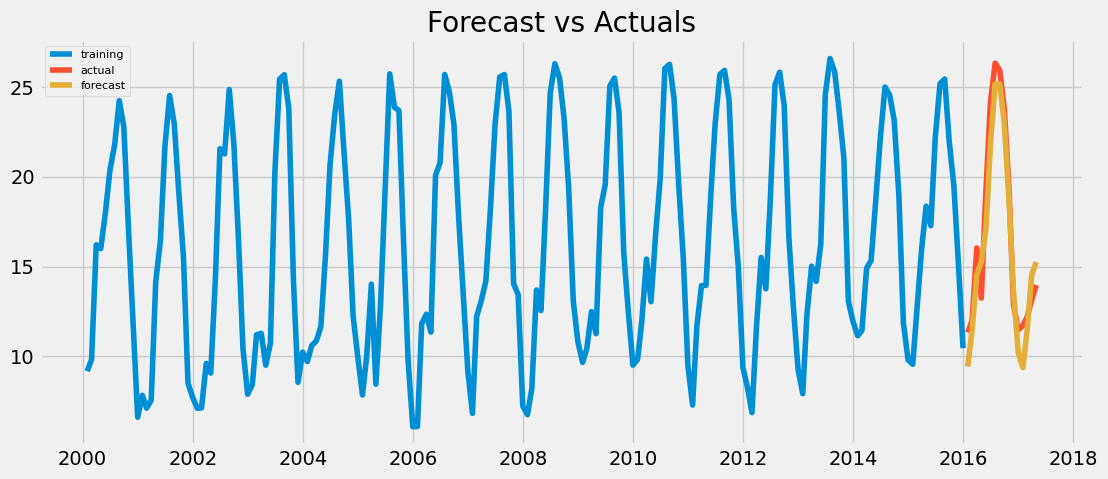

In [ ]:
# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(forecast, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

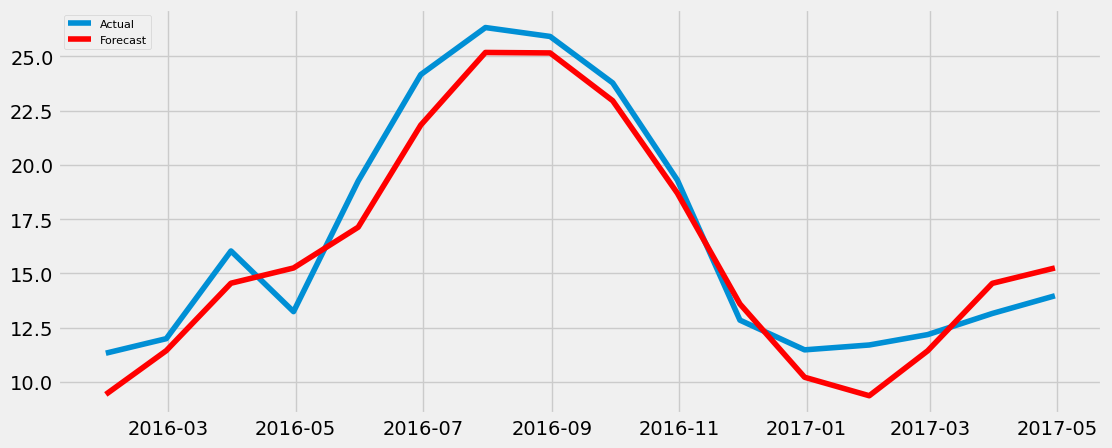

In [ ]:
# plot Testing and Forecasted data
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_df, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
error = mean_squared_error(test_df, forecast)
print('Test Mean Squared Error: ',error)

Test Mean Squared Error:  2.1717355159857057
